<a href="https://colab.research.google.com/github/T-Yamaguch/WGAN-gp/blob/master/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Fri Oct  2 20:12:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, \
MaxPooling2D, Activation, ReLU, LeakyReLU, UpSampling2D, BatchNormalization, \
Dropout, Dense, Flatten, Add, LayerNormalization, GaussianNoise, Reshape, Lambda
from keras.regularizers import l2

class up_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(up_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.up = UpSampling2D((2,2))
    self.noise = GaussianNoise(0.2)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.up(x)
    x = self.noise(x)
    return x

class res_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(res_block, self).__init__()
    self.conv1 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.conv2 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm1 = BatchNormalization(trainable=True)
    self.norm2 = BatchNormalization(trainable=True)
    self.act1 = LeakyReLU()
    self.act2 = LeakyReLU()
    self.add = Add()

  def call(self, x):
    y = self.conv1(x)
    y = self.norm1(y)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.norm2(y)
    y = self.act2(y)
    x = self.add([x, y])
    return x

class down_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(down_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.pooling = MaxPooling2D((2,2), strides=(2,2))
    self.drop = Dropout(0.3)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.pooling(x)
    x = self.drop(x)
    return x

class conv_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001), batch_norm = True):
    super(conv_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.drop = Dropout(0.3)
    self.batch_norm = batch_norm

  def call(self, x):
    x = self.conv(x)
    if self.batch_norm == True:
      x = self.norm(x)
    x = self.act(x)
    x = self.drop(x)
    return x

class dense_block(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001), batch_norm = True):
    super(dense_block, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = LeakyReLU()
    self.batch_norm = batch_norm

  def call(self, x):
    x = self.dense(x)
    if self.batch_norm == True:
      x = self.norm(x)
    x = self.act(x)
    return x


In [4]:
class Generator():
  def __init__(self):
    self.channel_num = 512
    self.layer_num = 5
    self.res_num = 0
    self.latent_num = 256
    self.inputs = Input(shape=(self.latent_num)) 
    self.kernel_size = (3, 3)
    self.name = 'generator'
    self.kernel_regularizer= None
      
  def model(self):
    x = self.inputs

    final_size = 4*4*self.channel_num
    data_size = self.latent_num

    # while data_size*64 < final_size:
    #   data_size *= 64
    #   x = dense_block(data_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = dense_block(final_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Reshape((4, 4, self.channel_num))(x)

    filter_num = self.channel_num
    
    for n in range(self.layer_num):
      for m in range(self.res_num):
        x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num /= 2
      x = up_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    for m in range(self.res_num):
      x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
    # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = Conv2D(3, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    x = Activation('sigmoid')(x)
    outputs = x
    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

g = Generator()
g.model().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_block (dense_block)    (None, 8192)              2138112   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
up_block (up_block)          (None, 8, 8, 256)         1180928   
_________________________________________________________________
up_block_1 (up_block)        (None, 16, 16, 128)       295552    
_________________________________________________________________
up_block_2 (up_block)        (None, 32, 32, 64)        74048     
_________________________________________________________________
up_block_3 (up_block)        (None, 64, 64, 32)        18

In [5]:
class Discriminator():
  def __init__(self):
    self.channel_num = 16
    self.layer_num = 5
    self.input_shape = (128, 128, 3)
    self.inputs = Input(shape=self.input_shape)
    self.kernel_size = (3, 3)
    self.name = 'discriminator'
    self.kernel_regularizer= None

  def model(self):
    x = self.inputs

    filter_num = self.channel_num
    for n in range(self.layer_num):
      # x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer, batch_norm = False)(x)
      x = down_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2

    x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Flatten()(x)
    outputs =  Dense(1, kernel_regularizer= self.kernel_regularizer)(x)

    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

d = Discriminator()
d.model().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
down_block (down_block)      (None, 64, 64, 16)        512       
_________________________________________________________________
down_block_1 (down_block)    (None, 32, 32, 32)        4768      
_________________________________________________________________
down_block_2 (down_block)    (None, 16, 16, 64)        18752     
_________________________________________________________________
down_block_3 (down_block)    (None, 8, 8, 128)         74368     
_________________________________________________________________
down_block_4 (down_block)    (None, 4, 4, 256)         296192    
_________________________________________________________________
conv_block (conv_block)      (None, 4, 4, 512)       


epochs 1
steps16
d loss: 7.9415, g loss: 0.0057
epoch time: 19.0486 [sec]

epochs 2
steps16
d loss: 6.8566, g loss: -0.0354
epoch time: 15.8249 [sec]

epochs 3
steps16
d loss: 5.5229, g loss: -0.0455
epoch time: 15.7954 [sec]

epochs 4
steps16
d loss: 4.0913, g loss: -0.0491
epoch time: 15.8017 [sec]

epochs 5
steps16
d loss: 2.6411, g loss: -0.0487
epoch time: 15.7867 [sec]

epochs 6
steps16
d loss: 1.0863, g loss: -0.0458
epoch time: 15.8247 [sec]

epochs 7
steps16
d loss: -0.3846, g loss: -0.0434
epoch time: 15.8095 [sec]

epochs 8
steps16
d loss: -1.7440, g loss: -0.0435
epoch time: 15.8043 [sec]

epochs 9
steps16
d loss: -2.9141, g loss: -0.0529
epoch time: 15.9627 [sec]

epochs 10
steps16
d loss: -3.8230, g loss: -0.0670
epoch time: 15.9179 [sec]


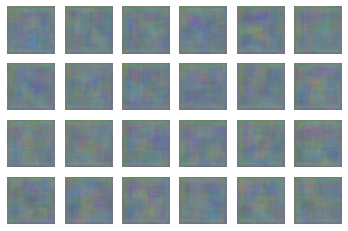

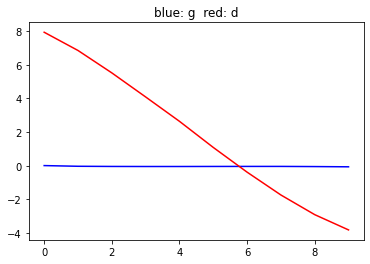


epochs 11
steps16
d loss: -4.3311, g loss: -0.0859
epoch time: 15.9010 [sec]

epochs 12
steps16
d loss: -4.3534, g loss: -0.1138
epoch time: 15.9058 [sec]

epochs 13
steps16
d loss: -3.9213, g loss: -0.1530
epoch time: 15.9321 [sec]

epochs 14
steps16
d loss: -2.8208, g loss: -0.2009
epoch time: 15.9942 [sec]

epochs 15
steps16
d loss: -1.3827, g loss: -0.2672
epoch time: 15.9379 [sec]

epochs 16
steps16
d loss: 0.4555, g loss: -0.3561
epoch time: 16.0081 [sec]

epochs 17
steps16
d loss: 2.4161, g loss: -0.4621
epoch time: 15.9830 [sec]

epochs 18
steps16
d loss: 4.2023, g loss: -0.5685
epoch time: 16.0694 [sec]

epochs 19
steps16
d loss: 5.7532, g loss: -0.6874
epoch time: 16.1144 [sec]

epochs 20
steps16
d loss: 7.1388, g loss: -0.7969
epoch time: 16.0554 [sec]


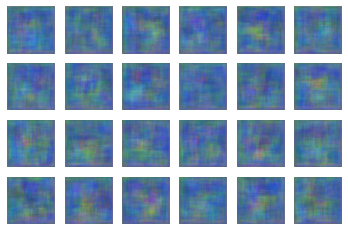

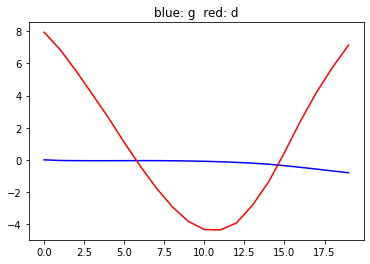


epochs 21
steps16
d loss: 7.7630, g loss: -0.9028
epoch time: 15.9266 [sec]

epochs 22
steps16
d loss: 8.0940, g loss: -0.9857
epoch time: 15.9694 [sec]

epochs 23
steps16
d loss: 7.8893, g loss: -1.0567
epoch time: 16.0413 [sec]

epochs 24
steps16
d loss: 7.3825, g loss: -1.1065
epoch time: 16.0751 [sec]

epochs 25
steps16
d loss: 6.9230, g loss: -1.1467
epoch time: 16.0424 [sec]

epochs 26
steps16
d loss: 6.2675, g loss: -1.1754
epoch time: 15.9209 [sec]

epochs 27
steps16
d loss: 5.6689, g loss: -1.1963
epoch time: 16.1984 [sec]

epochs 28
steps16
d loss: 5.0018, g loss: -1.2097
epoch time: 15.9916 [sec]

epochs 29
steps16
d loss: 4.1912, g loss: -1.2275
epoch time: 16.0761 [sec]

epochs 30
steps16
d loss: 3.5313, g loss: -1.2340
epoch time: 16.0188 [sec]


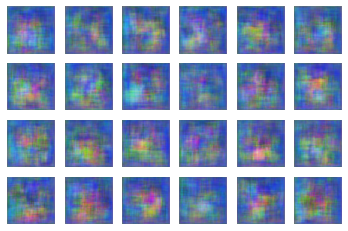

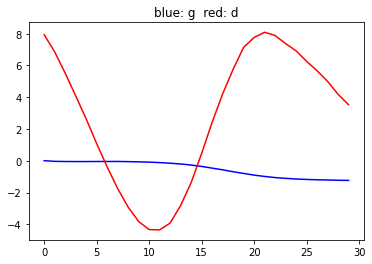


epochs 31
steps16
d loss: 3.2366, g loss: -1.2494
epoch time: 15.9566 [sec]

epochs 32
steps16
d loss: 2.5722, g loss: -1.2537
epoch time: 16.0290 [sec]

epochs 33
steps16
d loss: 2.2497, g loss: -1.2569
epoch time: 16.0443 [sec]

epochs 34
steps16
d loss: 1.8631, g loss: -1.2638
epoch time: 16.1501 [sec]

epochs 35
steps16
d loss: 1.5112, g loss: -1.2659
epoch time: 16.0326 [sec]

epochs 36
steps16
d loss: 1.2312, g loss: -1.2761
epoch time: 15.9989 [sec]

epochs 37
steps16
d loss: 0.9598, g loss: -1.2836
epoch time: 16.0670 [sec]

epochs 38
steps16
d loss: 0.7633, g loss: -1.2872
epoch time: 15.9702 [sec]

epochs 39
steps16
d loss: 0.5888, g loss: -1.2891
epoch time: 16.0110 [sec]

epochs 40
steps16
d loss: 0.4217, g loss: -1.2962
epoch time: 16.0469 [sec]


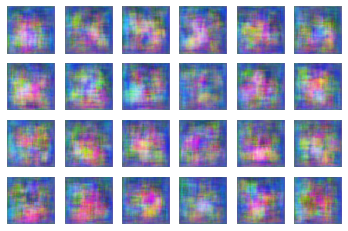

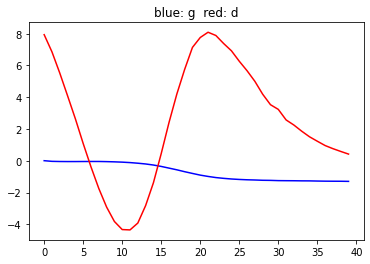


epochs 41
steps16
d loss: 0.2542, g loss: -1.2997
epoch time: 16.0274 [sec]

epochs 42
steps16
d loss: 0.1950, g loss: -1.3050
epoch time: 15.9924 [sec]

epochs 43
steps16
d loss: -0.0153, g loss: -1.3053
epoch time: 16.0153 [sec]

epochs 44
steps16
d loss: -0.0874, g loss: -1.3026
epoch time: 16.1221 [sec]

epochs 45
steps16
d loss: -0.1790, g loss: -1.3044
epoch time: 15.9723 [sec]

epochs 46
steps16
d loss: -0.3202, g loss: -1.3028
epoch time: 15.9917 [sec]

epochs 47
steps16
d loss: -0.4148, g loss: -1.2969
epoch time: 15.9360 [sec]

epochs 48
steps16
d loss: -0.4631, g loss: -1.2941
epoch time: 15.9800 [sec]

epochs 49
steps16
d loss: -0.5454, g loss: -1.2896
epoch time: 15.9759 [sec]

epochs 50
steps16
d loss: -0.6867, g loss: -1.2846
epoch time: 15.9531 [sec]


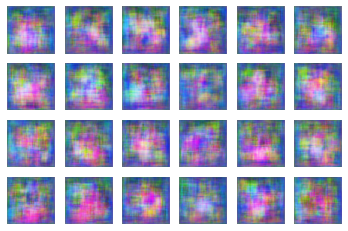

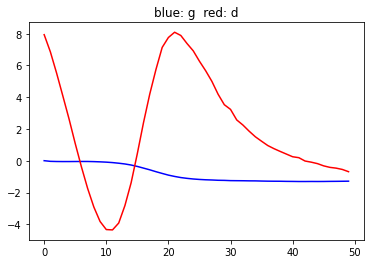


epochs 51
steps16
d loss: -0.7910, g loss: -1.2755
epoch time: 15.9399 [sec]

epochs 52
steps16
d loss: -0.8950, g loss: -1.2681
epoch time: 16.0677 [sec]

epochs 53
steps16
d loss: -1.0349, g loss: -1.2624
epoch time: 15.9563 [sec]

epochs 54
steps16
d loss: -1.0104, g loss: -1.2518
epoch time: 15.9505 [sec]

epochs 55
steps16
d loss: -1.2103, g loss: -1.2472
epoch time: 15.9344 [sec]

epochs 56
steps16
d loss: -1.3142, g loss: -1.2374
epoch time: 15.9592 [sec]

epochs 57
steps16
d loss: -1.3200, g loss: -1.2291
epoch time: 16.0112 [sec]

epochs 58
steps16
d loss: -1.4451, g loss: -1.2232
epoch time: 15.9354 [sec]

epochs 59
steps16
d loss: -1.4707, g loss: -1.2166
epoch time: 15.9472 [sec]

epochs 60
steps16
d loss: -1.5433, g loss: -1.2096
epoch time: 16.0449 [sec]


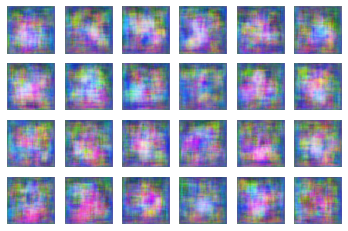

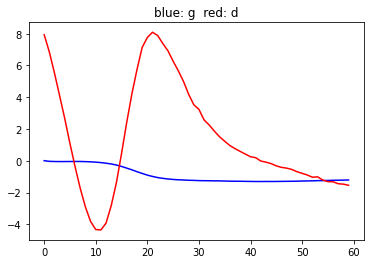


epochs 61
steps16
d loss: -1.6036, g loss: -1.2060
epoch time: 16.0765 [sec]

epochs 62
steps16
d loss: -1.6213, g loss: -1.2008
epoch time: 15.9494 [sec]

epochs 63
steps16
d loss: -1.7041, g loss: -1.1990
epoch time: 16.0145 [sec]

epochs 64
steps16
d loss: -1.7055, g loss: -1.1971
epoch time: 15.9404 [sec]

epochs 65
steps16
d loss: -1.7192, g loss: -1.1979
epoch time: 15.9465 [sec]

epochs 66
steps16
d loss: -1.7404, g loss: -1.2018
epoch time: 15.9964 [sec]

epochs 67
steps16
d loss: -1.6691, g loss: -1.2032
epoch time: 16.0181 [sec]

epochs 68
steps16
d loss: -1.7436, g loss: -1.2036
epoch time: 16.0583 [sec]

epochs 69
steps16
d loss: -1.7774, g loss: -1.2101
epoch time: 15.9239 [sec]

epochs 70
steps16
d loss: -1.7661, g loss: -1.2133
epoch time: 15.9687 [sec]


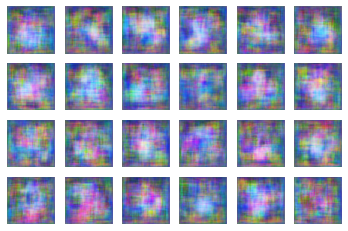

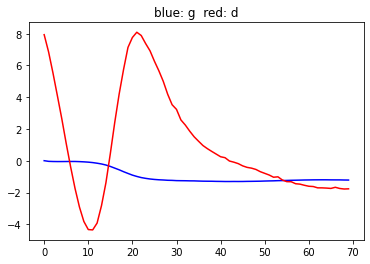


epochs 71
steps16
d loss: -1.7022, g loss: -1.2165
epoch time: 15.9533 [sec]

epochs 72
steps16
d loss: -1.7514, g loss: -1.2160
epoch time: 16.0175 [sec]

epochs 73
steps16
d loss: -1.7863, g loss: -1.2158
epoch time: 16.0479 [sec]

epochs 74
steps16
d loss: -1.8060, g loss: -1.2130
epoch time: 16.0099 [sec]

epochs 75
steps16
d loss: -1.8640, g loss: -1.2102
epoch time: 16.0125 [sec]

epochs 76
steps16
d loss: -1.8361, g loss: -1.2054
epoch time: 15.9379 [sec]

epochs 77
steps16
d loss: -1.9529, g loss: -1.1952
epoch time: 15.9919 [sec]

epochs 78
steps16
d loss: -1.8832, g loss: -1.1870
epoch time: 15.9990 [sec]

epochs 79
steps16
d loss: -1.9312, g loss: -1.1740
epoch time: 15.9389 [sec]

epochs 80
steps16
d loss: -1.9878, g loss: -1.1578
epoch time: 15.9657 [sec]


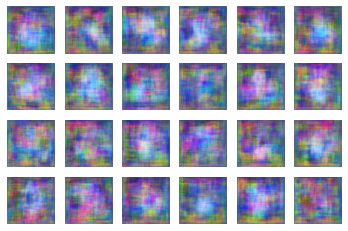

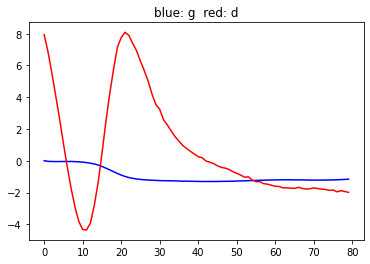


epochs 81
steps16
d loss: -2.0765, g loss: -1.1425
epoch time: 15.9742 [sec]

epochs 82
steps16
d loss: -2.1715, g loss: -1.1274
epoch time: 16.0528 [sec]

epochs 83
steps16
d loss: -2.1833, g loss: -1.1131
epoch time: 15.9860 [sec]

epochs 84
steps16
d loss: -2.2580, g loss: -1.1000
epoch time: 15.9184 [sec]

epochs 85
steps16
d loss: -2.2895, g loss: -1.0917
epoch time: 16.0508 [sec]

epochs 86
steps16
d loss: -2.3877, g loss: -1.0820
epoch time: 15.9898 [sec]

epochs 87
steps16
d loss: -2.3644, g loss: -1.0707
epoch time: 15.9616 [sec]

epochs 88
steps16
d loss: -2.3838, g loss: -1.0695
epoch time: 15.9829 [sec]

epochs 89
steps16
d loss: -2.5469, g loss: -1.0649
epoch time: 15.9520 [sec]

epochs 90
steps16
d loss: -2.5068, g loss: -1.0664
epoch time: 15.9740 [sec]


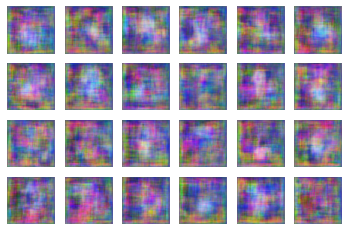

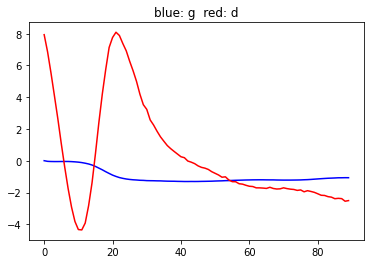


epochs 91
steps16
d loss: -2.4702, g loss: -1.0707
epoch time: 15.9501 [sec]

epochs 92
steps16
d loss: -2.5179, g loss: -1.0810
epoch time: 16.0634 [sec]

epochs 93
steps16
d loss: -2.4950, g loss: -1.0894
epoch time: 16.0251 [sec]

epochs 94
steps16
d loss: -2.5276, g loss: -1.1048
epoch time: 16.0103 [sec]

epochs 95
steps16
d loss: -2.4817, g loss: -1.1112
epoch time: 16.0255 [sec]

epochs 96
steps16
d loss: -2.3839, g loss: -1.1284
epoch time: 16.1124 [sec]

epochs 97
steps16
d loss: -2.3208, g loss: -1.1453
epoch time: 16.0045 [sec]

epochs 98
steps16
d loss: -2.1949, g loss: -1.1604
epoch time: 16.0777 [sec]

epochs 99
steps16
d loss: -2.2265, g loss: -1.1759
epoch time: 15.9700 [sec]

epochs 100
steps16
d loss: -2.0752, g loss: -1.1938
epoch time: 16.1508 [sec]


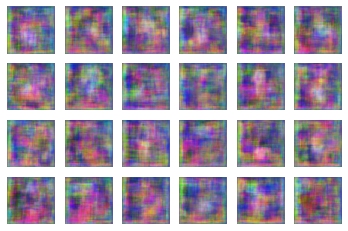

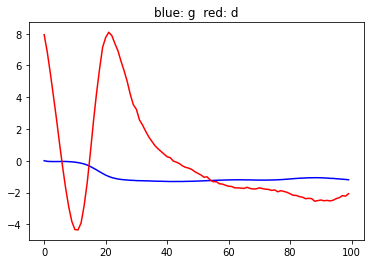


Saving checkpoint at epoch100



epochs 101
steps16
d loss: -1.9586, g loss: -1.2104
epoch time: 16.0007 [sec]

epochs 102
steps16
d loss: -1.8601, g loss: -1.2227
epoch time: 15.9532 [sec]

epochs 103
steps16
d loss: -1.7034, g loss: -1.2407
epoch time: 16.0171 [sec]

epochs 104
steps16
d loss: -1.6029, g loss: -1.2564
epoch time: 15.9418 [sec]

epochs 105
steps16
d loss: -1.4741, g loss: -1.2717
epoch time: 16.1039 [sec]

epochs 106
steps16
d loss: -1.3983, g loss: -1.2829
epoch time: 15.9943 [sec]

epochs 107
steps16
d loss: -1.2788, g loss: -1.3025
epoch time: 16.0763 [sec]

epochs 108
steps16
d loss: -1.2035, g loss: -1.3147
epoch time: 15.9855 [sec]

epochs 109
steps16
d loss: -1.2179, g loss: -1.3313
epoch time: 15.9624 [sec]

epochs 110
steps16
d loss: -1.0849, g loss: -1.3424
epoch time: 16.0279 [sec]


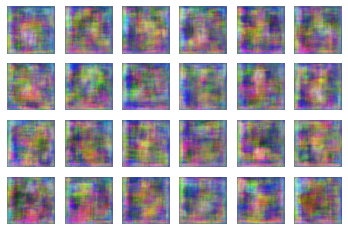

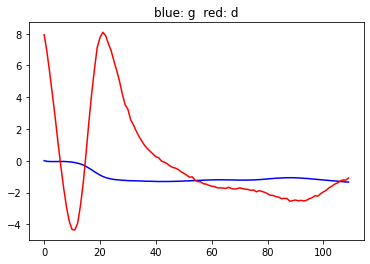


epochs 111
steps16
d loss: -1.1282, g loss: -1.3563
epoch time: 15.9854 [sec]

epochs 112
steps16
d loss: -1.0455, g loss: -1.3685
epoch time: 16.0438 [sec]

epochs 113
steps16
d loss: -1.0741, g loss: -1.3828
epoch time: 16.0428 [sec]

epochs 114
steps16
d loss: -1.1553, g loss: -1.3877
epoch time: 15.9514 [sec]

epochs 115
steps16
d loss: -1.1817, g loss: -1.3907
epoch time: 15.9775 [sec]

epochs 116
steps16
d loss: -1.1773, g loss: -1.3959
epoch time: 15.9743 [sec]

epochs 117
steps16
d loss: -1.3416, g loss: -1.4009
epoch time: 16.0372 [sec]

epochs 118
steps16
d loss: -1.4682, g loss: -1.4023
epoch time: 15.9625 [sec]

epochs 119
steps16
d loss: -1.5507, g loss: -1.4033
epoch time: 15.9528 [sec]

epochs 120
steps16
d loss: -1.5987, g loss: -1.4116
epoch time: 15.9646 [sec]


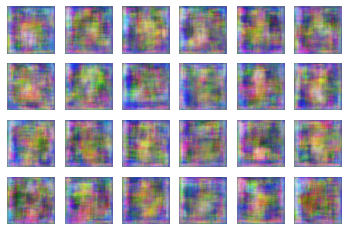

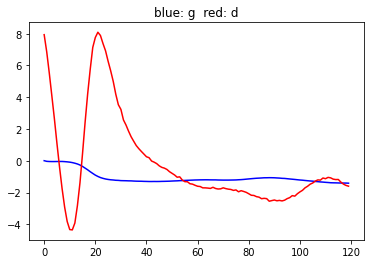


epochs 121
steps16
d loss: -1.6198, g loss: -1.4146
epoch time: 15.9844 [sec]

epochs 122
steps16
d loss: -1.9361, g loss: -1.4197
epoch time: 16.0583 [sec]

epochs 123
steps16
d loss: -1.9221, g loss: -1.4247
epoch time: 16.0593 [sec]

epochs 124
steps16
d loss: -2.0219, g loss: -1.4351
epoch time: 15.9782 [sec]

epochs 125
steps16
d loss: -2.0437, g loss: -1.4473
epoch time: 15.9979 [sec]

epochs 126
steps16
d loss: -2.1703, g loss: -1.4566
epoch time: 15.9685 [sec]

epochs 127
steps16
d loss: -2.2105, g loss: -1.4667
epoch time: 15.9552 [sec]

epochs 128
steps16
d loss: -2.2955, g loss: -1.4803
epoch time: 15.9647 [sec]

epochs 129
steps16
d loss: -2.2433, g loss: -1.4914
epoch time: 15.9785 [sec]

epochs 130
steps16
d loss: -2.2925, g loss: -1.5058
epoch time: 15.9774 [sec]


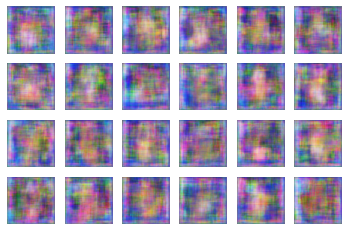

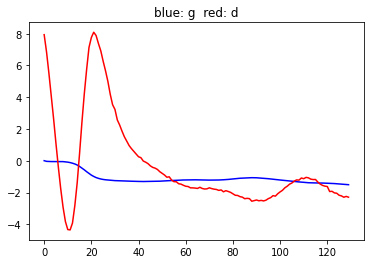


epochs 131
steps16
d loss: -2.4237, g loss: -1.5139
epoch time: 15.9550 [sec]

epochs 132
steps16
d loss: -2.4764, g loss: -1.5232
epoch time: 15.9760 [sec]

epochs 133
steps16
d loss: -2.4586, g loss: -1.5385
epoch time: 15.9944 [sec]

epochs 134
steps16
d loss: -2.5916, g loss: -1.5437
epoch time: 15.9394 [sec]

epochs 135
steps16
d loss: -2.6396, g loss: -1.5502
epoch time: 15.9712 [sec]

epochs 136
steps16
d loss: -2.5791, g loss: -1.5570
epoch time: 15.9202 [sec]

epochs 137
steps16
d loss: -2.6589, g loss: -1.5603
epoch time: 15.9792 [sec]

epochs 138
steps16
d loss: -2.6265, g loss: -1.5647
epoch time: 16.0159 [sec]

epochs 139
steps16
d loss: -2.6280, g loss: -1.5631
epoch time: 15.9788 [sec]

epochs 140
steps16
d loss: -2.5696, g loss: -1.5669
epoch time: 15.9614 [sec]


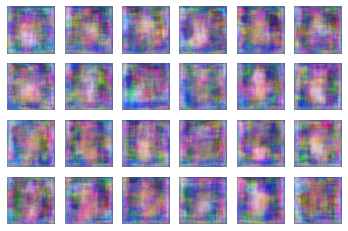

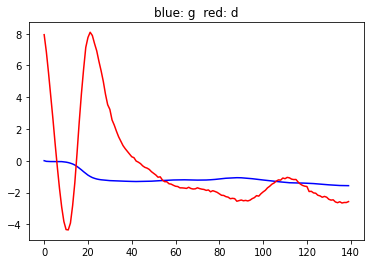


epochs 141
steps16
d loss: -2.4556, g loss: -1.5655
epoch time: 16.0167 [sec]

epochs 142
steps16
d loss: -2.5370, g loss: -1.5618
epoch time: 16.0426 [sec]

epochs 143
steps16
d loss: -2.4670, g loss: -1.5574
epoch time: 16.0419 [sec]

epochs 144
steps16
d loss: -2.3410, g loss: -1.5541
epoch time: 15.9960 [sec]

epochs 145
steps16
d loss: -2.4224, g loss: -1.5460
epoch time: 15.9464 [sec]

epochs 146
steps16
d loss: -2.2239, g loss: -1.5382
epoch time: 15.9651 [sec]

epochs 147
steps16
d loss: -2.1819, g loss: -1.5298
epoch time: 15.9284 [sec]

epochs 148
steps16
d loss: -2.0875, g loss: -1.5183
epoch time: 15.9429 [sec]

epochs 149
steps16
d loss: -2.0626, g loss: -1.5043
epoch time: 15.9566 [sec]

epochs 150
steps16
d loss: -1.9163, g loss: -1.4935
epoch time: 15.9681 [sec]


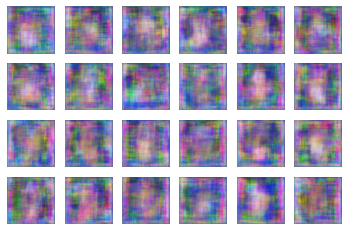

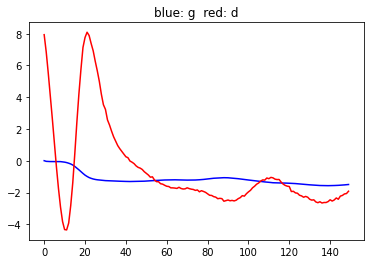


epochs 151
steps16
d loss: -1.9690, g loss: -1.4802
epoch time: 16.0164 [sec]

epochs 152
steps16
d loss: -1.9114, g loss: -1.4675
epoch time: 16.0443 [sec]

epochs 153
steps16
d loss: -1.8563, g loss: -1.4533
epoch time: 15.9804 [sec]

epochs 154
steps16
d loss: -1.7584, g loss: -1.4363
epoch time: 15.9848 [sec]

epochs 155
steps16
d loss: -1.7294, g loss: -1.4236
epoch time: 16.0045 [sec]

epochs 156
steps16
d loss: -1.8305, g loss: -1.4048
epoch time: 15.9396 [sec]

epochs 157
steps16
d loss: -1.8114, g loss: -1.3897
epoch time: 15.9294 [sec]

epochs 158
steps16
d loss: -1.8509, g loss: -1.3652
epoch time: 15.9941 [sec]

epochs 159
steps16
d loss: -1.7827, g loss: -1.3501
epoch time: 15.9807 [sec]

epochs 160
steps16
d loss: -1.9363, g loss: -1.3253
epoch time: 15.9516 [sec]


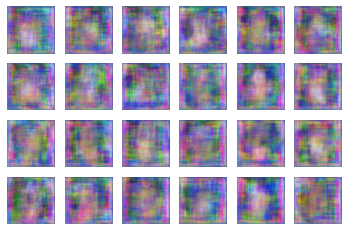

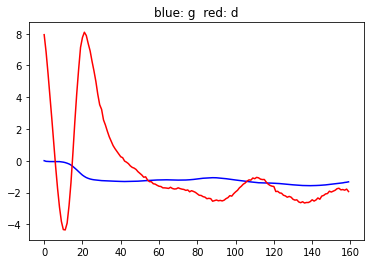


epochs 161
steps16
d loss: -1.9854, g loss: -1.3062
epoch time: 15.9331 [sec]

epochs 162
steps16
d loss: -2.1564, g loss: -1.2857
epoch time: 16.0266 [sec]

epochs 163
steps16
d loss: -2.1989, g loss: -1.2648
epoch time: 16.0214 [sec]

epochs 164
steps16
d loss: -2.1968, g loss: -1.2448
epoch time: 16.0188 [sec]

epochs 165
steps16
d loss: -2.3983, g loss: -1.2228
epoch time: 15.9401 [sec]

epochs 166
steps16
d loss: -2.5509, g loss: -1.2061
epoch time: 15.9809 [sec]

epochs 167
steps16
d loss: -2.5769, g loss: -1.1862
epoch time: 15.9663 [sec]

epochs 168
steps16
d loss: -2.7126, g loss: -1.1674
epoch time: 16.0809 [sec]

epochs 169
steps16
d loss: -2.8284, g loss: -1.1545
epoch time: 15.9644 [sec]

epochs 170
steps16
d loss: -2.9096, g loss: -1.1379
epoch time: 15.9820 [sec]


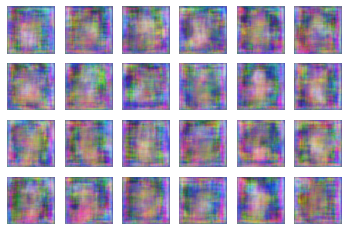

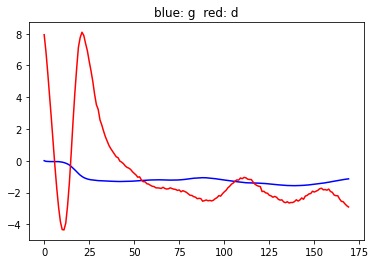


epochs 171
steps16
d loss: -3.0710, g loss: -1.1248
epoch time: 15.8995 [sec]

epochs 172
steps16
d loss: -3.1396, g loss: -1.1151
epoch time: 15.9749 [sec]

epochs 173
steps16
d loss: -3.2693, g loss: -1.1046
epoch time: 16.1694 [sec]

epochs 174
steps16
d loss: -3.2571, g loss: -1.0962
epoch time: 15.9996 [sec]

epochs 175
steps16
d loss: -3.3692, g loss: -1.0888
epoch time: 15.9474 [sec]

epochs 176
steps16
d loss: -3.4891, g loss: -1.0862
epoch time: 15.9290 [sec]

epochs 177
steps16
d loss: -3.4938, g loss: -1.0833
epoch time: 16.0226 [sec]

epochs 178
steps16
d loss: -3.6132, g loss: -1.0797
epoch time: 16.0127 [sec]

epochs 179
steps16
d loss: -3.5235, g loss: -1.0773
epoch time: 15.9563 [sec]

epochs 180
steps16
d loss: -3.7296, g loss: -1.0782
epoch time: 16.0261 [sec]


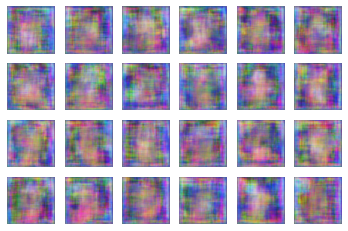

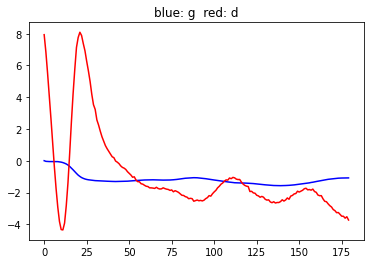


epochs 181
steps16
d loss: -3.5827, g loss: -1.0791
epoch time: 15.9790 [sec]

epochs 182
steps16
d loss: -3.6224, g loss: -1.0772
epoch time: 16.0363 [sec]

epochs 183
steps16
d loss: -3.6546, g loss: -1.0817
epoch time: 16.0720 [sec]

epochs 184
steps16
d loss: -3.7326, g loss: -1.0815
epoch time: 16.0345 [sec]

epochs 185
steps16
d loss: -3.6902, g loss: -1.0818
epoch time: 15.9558 [sec]

epochs 186
steps16
d loss: -3.7673, g loss: -1.0818
epoch time: 16.0955 [sec]

epochs 187
steps16
d loss: -3.8341, g loss: -1.0819
epoch time: 16.0212 [sec]

epochs 188
steps16
d loss: -3.7152, g loss: -1.0845
epoch time: 16.0026 [sec]

epochs 189
steps16
d loss: -3.8595, g loss: -1.0862
epoch time: 15.9288 [sec]

epochs 190
steps16
d loss: -3.8616, g loss: -1.0862
epoch time: 15.9751 [sec]


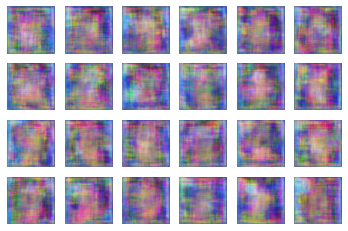

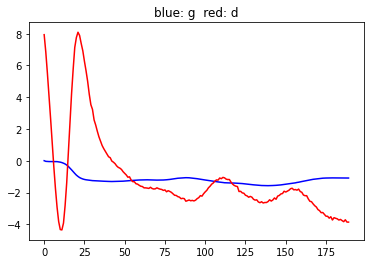


epochs 191
steps16
d loss: -3.8664, g loss: -1.0865
epoch time: 15.9656 [sec]

epochs 192
steps16
d loss: -3.8473, g loss: -1.0868
epoch time: 16.0709 [sec]

epochs 193
steps16
d loss: -3.9954, g loss: -1.0851
epoch time: 16.1268 [sec]

epochs 194
steps16
d loss: -3.9951, g loss: -1.0839
epoch time: 16.0739 [sec]

epochs 195
steps16
d loss: -4.0277, g loss: -1.0837
epoch time: 15.9705 [sec]

epochs 196
steps16
d loss: -4.1322, g loss: -1.0867
epoch time: 16.0327 [sec]

epochs 197
steps16
d loss: -4.1357, g loss: -1.0864
epoch time: 16.0047 [sec]

epochs 198
steps16
d loss: -4.2136, g loss: -1.0841
epoch time: 16.0077 [sec]

epochs 199
steps16
d loss: -4.1965, g loss: -1.0826
epoch time: 16.0044 [sec]

epochs 200
steps16
d loss: -4.3370, g loss: -1.0823
epoch time: 16.1078 [sec]


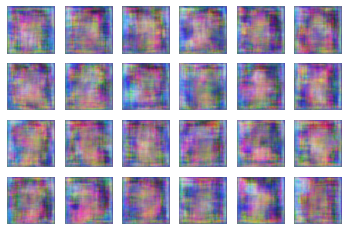

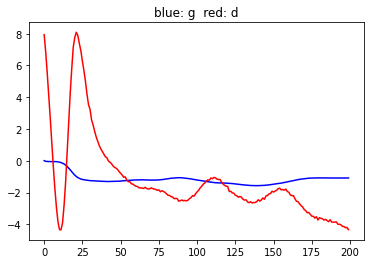


Saving checkpoint at epoch200



epochs 201
steps16
d loss: -4.2296, g loss: -1.0827
epoch time: 15.9058 [sec]

epochs 202
steps16
d loss: -4.1572, g loss: -1.0819
epoch time: 16.0468 [sec]

epochs 203
steps16
d loss: -4.3182, g loss: -1.0767
epoch time: 15.9964 [sec]

epochs 204
steps16
d loss: -4.2989, g loss: -1.0780
epoch time: 16.0223 [sec]

epochs 205
steps16
d loss: -4.2848, g loss: -1.0769
epoch time: 15.9872 [sec]

epochs 206
steps16
d loss: -4.2839, g loss: -1.0734
epoch time: 16.0070 [sec]

epochs 207
steps16
d loss: -4.2951, g loss: -1.0656
epoch time: 16.0404 [sec]

epochs 208
steps16
d loss: -4.2986, g loss: -1.0634
epoch time: 16.0745 [sec]

epochs 209
steps16
d loss: -4.3655, g loss: -1.0581
epoch time: 16.0116 [sec]

epochs 210
steps16
d loss: -4.3121, g loss: -1.0523
epoch time: 15.9926 [sec]


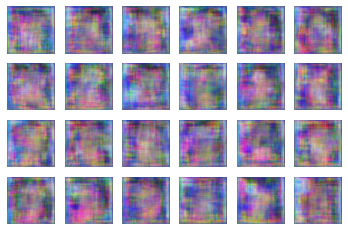

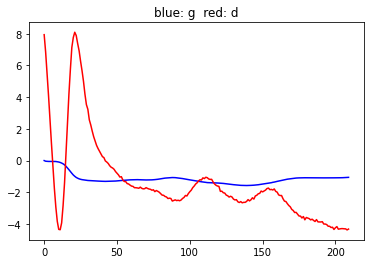


epochs 211
steps16
d loss: -4.3167, g loss: -1.0439
epoch time: 16.0074 [sec]

epochs 212
steps16
d loss: -4.3710, g loss: -1.0409
epoch time: 16.1025 [sec]

epochs 213
steps16
d loss: -4.2497, g loss: -1.0324
epoch time: 16.0910 [sec]

epochs 214
steps16
d loss: -4.3762, g loss: -1.0300
epoch time: 16.0097 [sec]

epochs 215
steps16
d loss: -4.4265, g loss: -1.0257
epoch time: 15.9468 [sec]

epochs 216
steps16
d loss: -4.4738, g loss: -1.0218
epoch time: 16.0096 [sec]

epochs 217
steps16
d loss: -4.5269, g loss: -1.0191
epoch time: 15.9675 [sec]

epochs 218
steps16
d loss: -4.5736, g loss: -1.0191
epoch time: 16.0285 [sec]

epochs 219
steps16
d loss: -4.7373, g loss: -1.0170
epoch time: 16.0105 [sec]

epochs 220
steps16
d loss: -4.5964, g loss: -1.0162
epoch time: 15.9617 [sec]


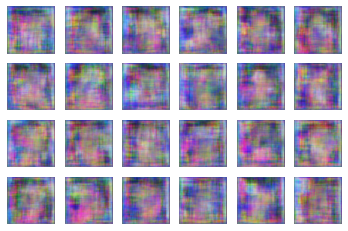

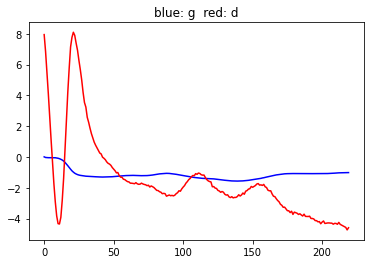


epochs 221
steps16
d loss: -4.7566, g loss: -1.0151
epoch time: 15.9504 [sec]

epochs 222
steps16
d loss: -4.7464, g loss: -1.0188
epoch time: 16.0330 [sec]

epochs 223
steps16
d loss: -4.8564, g loss: -1.0175
epoch time: 16.0301 [sec]

epochs 224
steps16
d loss: -4.9556, g loss: -1.0223
epoch time: 16.0327 [sec]

epochs 225
steps16
d loss: -5.0479, g loss: -1.0263
epoch time: 15.9731 [sec]

epochs 226
steps16
d loss: -5.0959, g loss: -1.0294
epoch time: 16.0250 [sec]

epochs 227
steps16
d loss: -5.2639, g loss: -1.0344
epoch time: 15.9633 [sec]

epochs 228
steps16
d loss: -5.2197, g loss: -1.0368
epoch time: 15.9679 [sec]

epochs 229
steps16
d loss: -5.3909, g loss: -1.0388
epoch time: 16.0016 [sec]

epochs 230
steps16
d loss: -5.4198, g loss: -1.0433
epoch time: 16.0368 [sec]


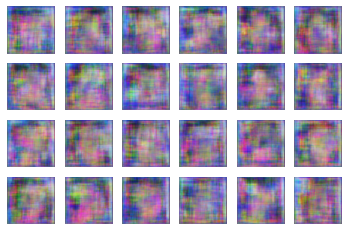

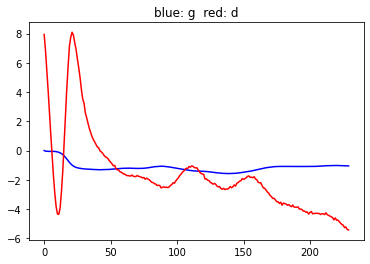


epochs 231
steps16
d loss: -5.4754, g loss: -1.0453
epoch time: 16.1865 [sec]

epochs 232
steps16
d loss: -5.4773, g loss: -1.0466
epoch time: 16.0262 [sec]

epochs 233
steps16
d loss: -5.5605, g loss: -1.0522
epoch time: 15.9949 [sec]

epochs 234
steps16
d loss: -5.6892, g loss: -1.0527
epoch time: 15.9467 [sec]

epochs 235
steps16
d loss: -5.7178, g loss: -1.0541
epoch time: 15.9244 [sec]

epochs 236
steps16
d loss: -5.7816, g loss: -1.0590
epoch time: 15.9942 [sec]

epochs 237
steps16
d loss: -5.7860, g loss: -1.0618
epoch time: 15.9502 [sec]

epochs 238
steps16
d loss: -5.7609, g loss: -1.0643
epoch time: 16.0192 [sec]

epochs 239
steps16
d loss: -5.8747, g loss: -1.0646
epoch time: 16.0071 [sec]

epochs 240
steps16
d loss: -5.9196, g loss: -1.0667
epoch time: 15.9334 [sec]


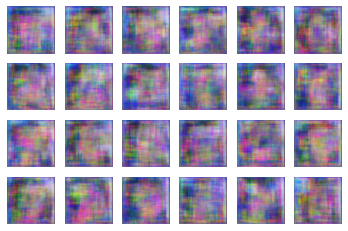

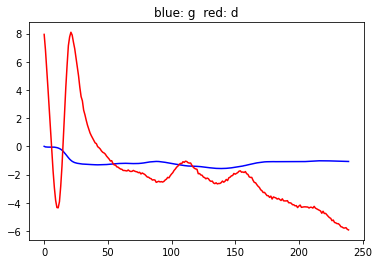


epochs 241
steps16
d loss: -5.9112, g loss: -1.0685
epoch time: 15.9524 [sec]

epochs 242
steps16
d loss: -5.8157, g loss: -1.0709
epoch time: 15.9597 [sec]

epochs 243
steps16
d loss: -5.8414, g loss: -1.0771
epoch time: 16.0157 [sec]

epochs 244
steps16
d loss: -5.9713, g loss: -1.0794
epoch time: 15.9134 [sec]

epochs 245
steps16
d loss: -5.9753, g loss: -1.0846
epoch time: 16.0412 [sec]

epochs 246
steps16
d loss: -5.9625, g loss: -1.0931
epoch time: 15.9743 [sec]

epochs 247
steps16
d loss: -5.8914, g loss: -1.0966
epoch time: 16.0290 [sec]

epochs 248
steps16
d loss: -6.0357, g loss: -1.1058
epoch time: 16.0016 [sec]

epochs 249
steps16
d loss: -5.8747, g loss: -1.1179
epoch time: 15.9256 [sec]

epochs 250
steps16
d loss: -5.8550, g loss: -1.1250
epoch time: 15.9367 [sec]


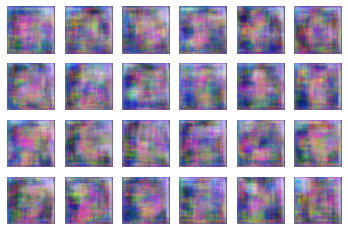

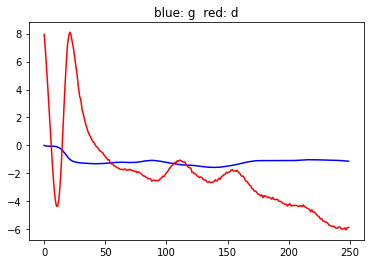


epochs 251
steps16
d loss: -5.9406, g loss: -1.1339
epoch time: 15.9552 [sec]

epochs 252
steps16
d loss: -5.8254, g loss: -1.1453
epoch time: 15.9780 [sec]

epochs 253
steps16
d loss: -5.8179, g loss: -1.1488
epoch time: 15.9999 [sec]

epochs 254
steps16
d loss: -5.9130, g loss: -1.1606
epoch time: 16.0090 [sec]

epochs 255
steps16
d loss: -5.8173, g loss: -1.1678
epoch time: 15.8996 [sec]

epochs 256
steps16
d loss: -5.9426, g loss: -1.1777
epoch time: 15.9500 [sec]

epochs 257
steps16
d loss: -5.8081, g loss: -1.1866
epoch time: 15.9717 [sec]

epochs 258
steps16
d loss: -5.9096, g loss: -1.1985
epoch time: 16.0374 [sec]

epochs 259
steps16
d loss: -5.7528, g loss: -1.2071
epoch time: 16.0131 [sec]

epochs 260
steps16
d loss: -5.8166, g loss: -1.2143
epoch time: 16.0200 [sec]


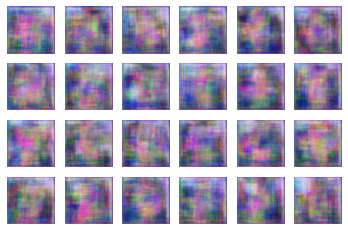

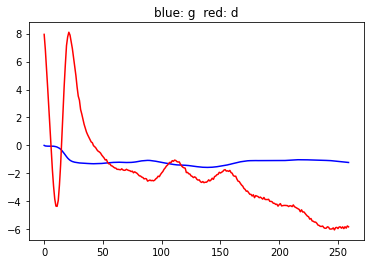


epochs 261
steps16
d loss: -5.8894, g loss: -1.2162
epoch time: 16.1211 [sec]

epochs 262
steps16
d loss: -5.9553, g loss: -1.2194
epoch time: 15.9799 [sec]

epochs 263
steps16
d loss: -5.9364, g loss: -1.2246
epoch time: 15.9630 [sec]

epochs 264
steps16
d loss: -6.0564, g loss: -1.2209
epoch time: 15.9598 [sec]

epochs 265
steps16
d loss: -6.3056, g loss: -1.2216
epoch time: 16.0215 [sec]

epochs 266
steps16
d loss: -6.3490, g loss: -1.2174
epoch time: 15.9345 [sec]

epochs 267
steps16
d loss: -6.4753, g loss: -1.2167
epoch time: 16.0655 [sec]

epochs 268
steps16
d loss: -6.6462, g loss: -1.2099
epoch time: 15.9499 [sec]

epochs 269
steps16
d loss: -6.7596, g loss: -1.2094
epoch time: 15.9226 [sec]

epochs 270
steps16
d loss: -7.1555, g loss: -1.2024
epoch time: 16.0741 [sec]


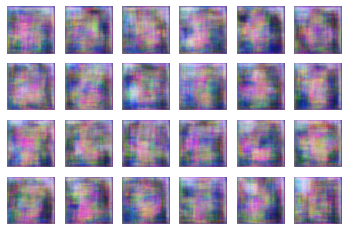

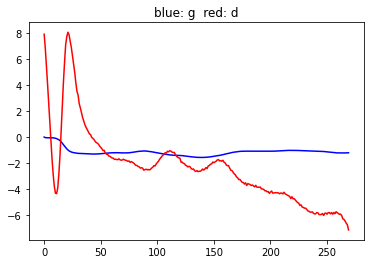


epochs 271
steps16
d loss: -7.0055, g loss: -1.1976
epoch time: 15.9732 [sec]

epochs 272
steps16
d loss: -7.1550, g loss: -1.1895
epoch time: 16.1112 [sec]

epochs 273
steps16
d loss: -7.4995, g loss: -1.1855
epoch time: 16.1562 [sec]

epochs 274
steps16
d loss: -7.5834, g loss: -1.1856
epoch time: 16.0386 [sec]

epochs 275
steps16
d loss: -7.7260, g loss: -1.1827
epoch time: 16.0539 [sec]

epochs 276
steps16
d loss: -7.6885, g loss: -1.1828
epoch time: 15.9590 [sec]

epochs 277
steps16
d loss: -7.9661, g loss: -1.1914
epoch time: 16.0007 [sec]

epochs 278
steps16
d loss: -8.0466, g loss: -1.1952
epoch time: 16.0353 [sec]

epochs 279
steps16
d loss: -7.9744, g loss: -1.2070
epoch time: 16.0452 [sec]

epochs 280
steps16
d loss: -8.3106, g loss: -1.2126
epoch time: 15.9972 [sec]


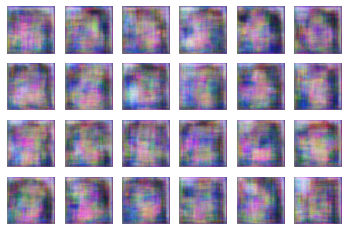

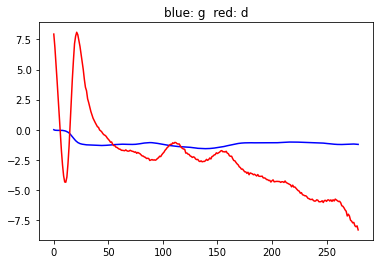


epochs 281
steps16
d loss: -8.3505, g loss: -1.2233
epoch time: 16.0173 [sec]

epochs 282
steps16
d loss: -8.4710, g loss: -1.2363
epoch time: 16.0243 [sec]

epochs 283
steps16
d loss: -8.7774, g loss: -1.2502
epoch time: 16.0019 [sec]

epochs 284
steps16
d loss: -8.7812, g loss: -1.2653
epoch time: 16.0030 [sec]

epochs 285
steps16
d loss: -8.9974, g loss: -1.2799
epoch time: 16.1498 [sec]

epochs 286
steps16
d loss: -9.1622, g loss: -1.2950
epoch time: 15.9779 [sec]

epochs 287
steps16
d loss: -9.3181, g loss: -1.3132
epoch time: 15.9530 [sec]

epochs 288
steps16
d loss: -9.3837, g loss: -1.3274
epoch time: 15.9908 [sec]

epochs 289
steps16
d loss: -9.5677, g loss: -1.3407
epoch time: 16.0031 [sec]

epochs 290
steps16
d loss: -9.6994, g loss: -1.3530
epoch time: 16.0155 [sec]


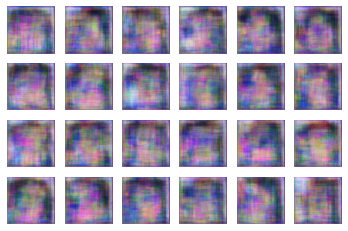

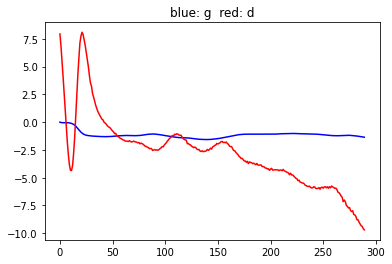


epochs 291
steps16
d loss: -9.8156, g loss: -1.3652
epoch time: 16.1648 [sec]

epochs 292
steps16
d loss: -9.6894, g loss: -1.3817
epoch time: 16.0358 [sec]

epochs 293
steps16
d loss: -9.5699, g loss: -1.3917
epoch time: 15.9552 [sec]

epochs 294
steps16
d loss: -9.4035, g loss: -1.4081
epoch time: 15.9666 [sec]

epochs 295
steps16
d loss: -9.2626, g loss: -1.4156
epoch time: 15.9903 [sec]

epochs 296
steps16
d loss: -9.3516, g loss: -1.4240
epoch time: 15.9798 [sec]

epochs 297
steps16
d loss: -9.0784, g loss: -1.4326
epoch time: 15.9393 [sec]

epochs 298
steps16
d loss: -8.7597, g loss: -1.4332
epoch time: 16.0279 [sec]

epochs 299
steps16
d loss: -8.6517, g loss: -1.4346
epoch time: 16.0640 [sec]

epochs 300
steps16
d loss: -8.6424, g loss: -1.4373
epoch time: 16.0800 [sec]


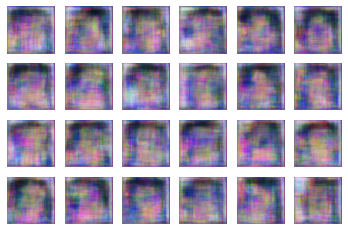

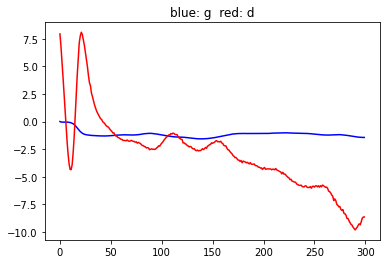


Saving checkpoint at epoch300



epochs 301
steps16
d loss: -8.5080, g loss: -1.4336
epoch time: 15.9713 [sec]

epochs 302
steps16
d loss: -8.1652, g loss: -1.4311
epoch time: 15.9451 [sec]

epochs 303
steps16
d loss: -8.0069, g loss: -1.4288
epoch time: 16.0643 [sec]

epochs 304
steps16
d loss: -8.0300, g loss: -1.4242
epoch time: 16.0324 [sec]

epochs 305
steps16
d loss: -7.9602, g loss: -1.4203
epoch time: 16.0039 [sec]

epochs 306
steps16
d loss: -8.1597, g loss: -1.4086
epoch time: 15.9424 [sec]

epochs 307
steps16
d loss: -8.0364, g loss: -1.4062
epoch time: 16.0636 [sec]

epochs 308
steps16
d loss: -7.9612, g loss: -1.3974
epoch time: 16.0160 [sec]

epochs 309
steps16
d loss: -7.7626, g loss: -1.3858
epoch time: 15.9792 [sec]

epochs 310
steps16
d loss: -7.7694, g loss: -1.3768
epoch time: 15.9900 [sec]


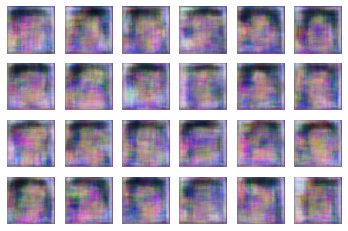

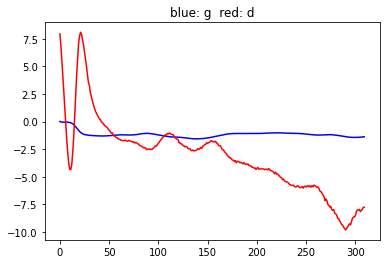


epochs 311
steps16
d loss: -7.7353, g loss: -1.3651
epoch time: 15.9484 [sec]

epochs 312
steps16
d loss: -7.8890, g loss: -1.3556
epoch time: 15.9669 [sec]

epochs 313
steps16
d loss: -7.6638, g loss: -1.3425
epoch time: 15.9982 [sec]

epochs 314
steps16
d loss: -7.8075, g loss: -1.3273
epoch time: 15.9713 [sec]

epochs 315
steps16
d loss: -7.7810, g loss: -1.3070
epoch time: 15.9469 [sec]

epochs 316
steps16
d loss: -7.7624, g loss: -1.2765
epoch time: 15.9379 [sec]

epochs 317
steps16
d loss: -7.9229, g loss: -1.2500
epoch time: 16.0390 [sec]

epochs 318
steps16
d loss: -7.9894, g loss: -1.2183
epoch time: 15.9729 [sec]

epochs 319
steps16
d loss: -8.1351, g loss: -1.1816
epoch time: 16.0400 [sec]

epochs 320
steps16
d loss: -7.9435, g loss: -1.1394
epoch time: 15.9712 [sec]


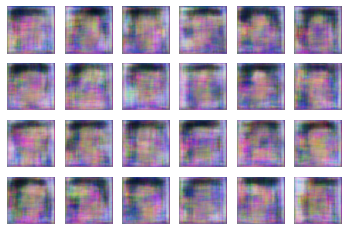

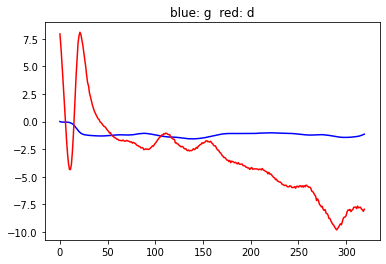


epochs 321
steps16
d loss: -8.1788, g loss: -1.0969
epoch time: 15.9973 [sec]

epochs 322
steps16
d loss: -8.1870, g loss: -1.0569
epoch time: 16.0704 [sec]

epochs 323
steps16
d loss: -8.1706, g loss: -1.0142
epoch time: 16.0688 [sec]

epochs 324
steps16
d loss: -8.4012, g loss: -0.9674
epoch time: 15.9803 [sec]

epochs 325
steps16
d loss: -8.4737, g loss: -0.9136
epoch time: 15.9364 [sec]

epochs 326
steps16
d loss: -8.5421, g loss: -0.8652
epoch time: 15.9279 [sec]

epochs 327
steps16
d loss: -8.5951, g loss: -0.8141
epoch time: 15.9086 [sec]

epochs 328
steps16
d loss: -8.6682, g loss: -0.7591
epoch time: 15.9561 [sec]

epochs 329
steps16
d loss: -8.7853, g loss: -0.7038
epoch time: 15.9584 [sec]

epochs 330
steps16
d loss: -8.9639, g loss: -0.6493
epoch time: 15.9902 [sec]


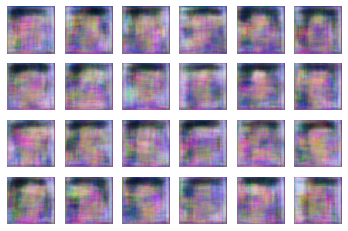

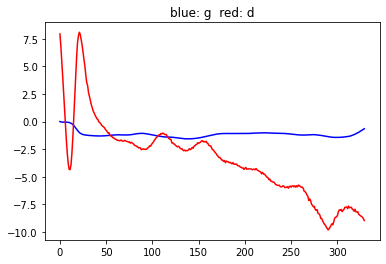


epochs 331
steps16
d loss: -9.0335, g loss: -0.5982
epoch time: 15.9688 [sec]

epochs 332
steps16
d loss: -9.2848, g loss: -0.5515
epoch time: 16.0644 [sec]

epochs 333
steps16
d loss: -9.2810, g loss: -0.5075
epoch time: 16.0424 [sec]

epochs 334
steps16
d loss: -9.4242, g loss: -0.4641
epoch time: 16.0337 [sec]

epochs 335
steps8

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, MSE
import glob
import time
import random
import sys

class WGAN():
  def __init__(self, 
               img_size= 128, 
               code_num = 2048,
               batch_size = 16, 
               train_epochs = 100, 
               train_steps = 8, 
               checkpoint_epochs = 25, 
               image_epochs = 1, 
               start_epoch = 1,
               optimizer = Adam(learning_rate = 1e-4),
               n_critics = 8,
               gp_lamda = 0.1
               ):
    
    self.batch_size = batch_size
    self.train_epochs =  train_epochs
    self.train_steps = train_steps
    self.checkpoint_epochs = checkpoint_epochs
    self.image_epochs = image_epochs
    self.start_epoch = start_epoch
    self.code_num = code_num
    self.img_size = img_size
    self.n_critics = n_critics
    self.gp_lamda = gp_lamda
    
    self.gen_optimizer = optimizer
    self.disc_optimizer = optimizer

    g = Generator()
    self.gen = g.model()
    
    d = Discriminator()
    self.disc = d.model()

    checkpoint_dir = "drive/My Drive/WGAN-gp/checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(gen_optimizer = self.gen_optimizer,
                                     disc_optimizer = self.disc_optimizer,
                                     gen = self.gen,
                                     disc = self.disc,
                                     )

    self.manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

    train_image_path = 'drive/My Drive/samples/image'
    
    self.train_filenames = glob.glob(train_image_path + '/*.jpg') 

    checkpoint.restore(self.manager.latest_checkpoint)

    self.g_history = []
    self.d_history = []
    # self.endec_history = []  

  def preprocess_image(self, image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [self.img_size, self.img_size] )
    image = image/255  # normalize to [0,1] range
    return tf.cast(image, tf.float32)

  def load_and_preprocess_image(self, path):
    image = tf.io.read_file(path)
    return self.preprocess_image(image)

  def dataset(self, paths, batch_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(self.load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    img_ds = img_ds.batch(batch_size)
    return img_ds

  def image_preparation(self, filenames, batch_size, steps):
    img_batch = []
    while 1:
      random.shuffle(filenames)
      for path in filenames:
        img_batch.append(path)
        if len(img_batch) == steps*batch_size:
          imgs = self.dataset(img_batch, batch_size)
          img_batch = []
          yield imgs

  def discriminator_loss(self, original_outputs, generated_outputs):
    real_loss = binary_crossentropy(tf.ones_like(original_outputs), original_outputs)
    generated_loss = binary_crossentropy(tf.zeros_like(generated_outputs), generated_outputs)
    loss_d = tf.math.reduce_mean(real_loss + generated_loss)
    return loss_d

  def generator_loss(self, generated_outputs):
    loss_g = tf.math.reduce_mean(binary_crossentropy(tf.ones_like(generated_outputs), generated_outputs))
    return loss_g

  def mse_loss(self, true, pred):
    loss =  tf.math.reduce_mean(MSE(true, pred))
    return loss

  def wasserstein_loss(self, ori_outputs, gen_outputs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)
    return d_loss, g_loss

  def w_gp_loss(self, ori_outputs, gen_outputs, imgs, gen_imgs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)

    alpha = tf.random.uniform(shape=[self.batch_size, 1, 1, 1], minval=0, maxval=1, dtype=tf.dtypes.float32)
    inter_sample = alpha * imgs + (1-alpha) * gen_imgs
    with tf.GradientTape() as tape_gp:
      tape_gp.watch(inter_sample)
      inter_score = self.disc(inter_sample)
    gp_gradients = tape_gp.gradient(inter_score, inter_sample)
    gp_gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis = [1, 2, 3]))
    gp = tf.reduce_mean((gp_gradients_norm - 1.0) ** 2)

    d_loss += gp * self.gp_lamda
    
    return d_loss, g_loss


  def g_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=False)
      gen_outputs = self.disc(gen_imgs, training=False)

      _, g_loss = self.w_gp_loss(ori_outputs, gen_outputs, imgs, gen_imgs)
      self.g_temp.append(g_loss)

    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

  def d_train(self, imgs):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=False)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)
      
      d_loss, _ = self.w_gp_loss(ori_outputs, gen_outputs, imgs, gen_imgs)
      self.d_temp.append(d_loss)

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def visualise_batch(self, s_1, epoch):
    gen_img = self.gen(s_1)  
    gen_img = (np.array(gen_img*255, np.uint8))
    fig, axes = plt.subplots(4, 6)
    for idx, img in enumerate(gen_img):
      p, q = idx//6, idx%6
      axes[p, q].imshow(img)
      axes[p, q].axis('off')
    
    save_name = 'drive/My Drive/WGAN-gp/generated_image/'+'image_at_epoch_{:04d}.png'
    plt.savefig(save_name.format(epoch), dpi=200)
    plt.pause(0.1)
    plt.close('all')

  def loss_vis(self):
    plt.plot(self.g_history, 'b', self.d_history, 'r')
    plt.title('blue: g  red: d')
    plt.savefig('drive/My Drive/WGAN-gp/loss/gan_loss.png')
    plt.pause(0.1)
    plt.close('all')

  def update_loss_history(self):
    d_batch_loss = sum(self.d_temp)/len(self.d_temp)
    g_batch_loss = sum(self.g_temp)/len(self.g_temp)
    print ('\nd loss: {:.4f}, g loss: {:.4f}'.format(d_batch_loss, g_batch_loss))
    self.d_history.append(d_batch_loss)
    self.g_history.append(g_batch_loss)
    self.d_temp = []
    self.g_temp = []

  def __call__(self):
    sample_noise =tf.random.uniform([24, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)
    image_loader = self.image_preparation(self.train_filenames, self.batch_size, self.train_steps)
    self.d_temp = []
    self.g_temp = []

    for epoch in range(self.start_epoch, self.train_epochs+1):
      
      start_time = time.time()

      print ('\nepochs {}'.format(epoch))
      imgs_ds = next(image_loader)

      for steps, imgs in enumerate(imgs_ds):
        print("\r" + 'steps{}'.format(steps+1), end="")
        sys.stdout.flush()

        self.d_train(imgs)

        if steps % self.n_critics == 0:
          self.g_train(imgs)
        
      self.update_loss_history()

      epoch_time = time.time() - start_time
      print ("epoch time: {:.4f} [sec]".format(epoch_time))
                               
      if epoch % self.image_epochs == 0:
        self.visualise_batch(sample_noise, epoch)
        self.loss_vis()

      if epoch % self.checkpoint_epochs == 0:
        print ('\nSaving checkpoint at epoch{}\n\n'.format(epoch))
        self.manager.save()
      
if __name__ == '__main__':
  a = WGAN(img_size = 128,
           code_num = 256,
           batch_size = 128,
           train_epochs = 10000, 
           train_steps = 16,
           checkpoint_epochs = 100, 
           image_epochs = 10, 
           start_epoch = 1,
           optimizer = Adam(learning_rate = 1e-6),
           n_critics = 1,
           gp_lamda = 10
           )
  a()